In [ ]:
# NOTE: you must install the version of pypulseq that matches the .seq file,
# becuase pypulseq file loading is not backwards compatible.

# for 1.3 files:
#!pip install pypulseq==1.3.1post1 &> /dev/null
# for 1.4 files, use one of:
!pip install pypulseq &> /dev/null

!pip install MRzeroCore --no-deps &> /dev/null
!pip install pydisseqt
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(mr0_upload_seq)=
# Upload own seq files
Here  you can upload and simulate own seq files.
Some tested seq-files can be found [here](https://drive.google.com/drive/folders/1EfQRpSXypv3O-t8qn0C6m16xlya_B2Pg). You can download them and then reupload one of these, or an own own seq-file and then simulate them in a brain phantom.


In [2]:
#@title 1. Imports
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [ ]:
#@title 2. upload seq file
try:
    # This only runs on google colab
    from google.colab import files
    uploaded = files.upload()
    seq_file = next(iter(uploaded))
except ImportError:
    # Local example file for doc build
    seq_file = "tse_pypulseq.seq"

seq = pp.Sequence()
seq.read(seq_file)

In [4]:
#@title 3. Set up spin system and simulate sequence
plot_phantom = False #@param {type:"boolean"}
pixel_phantom = False #@param {type:"boolean"}

print('load phantom')
if pixel_phantom:
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.25, -0.25, 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
else:
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
    brain_phantom_res = 64 #@param {type:"slider", min:16, max:128, step:16}
    obj_p = obj_p.interpolate(brain_phantom_res, brain_phantom_res, 1)
    obj_p.B0[:] = 0
    # obj_p.D[:] = 0

if plot_phantom:
    obj_p.plot()
obj_p = obj_p.build()

# obj_p.size = torch.tensor([0.3, 0.5, 0.003])

print('simulate (2D) \n' + seq_file)

# exact_trajectories are only important for diffusion weighted sequences
seq0 = mr0.Sequence.import_file(seq_file)

# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=True)

load phantom
simulate (2D) 
qa_FLASH_axial.seq


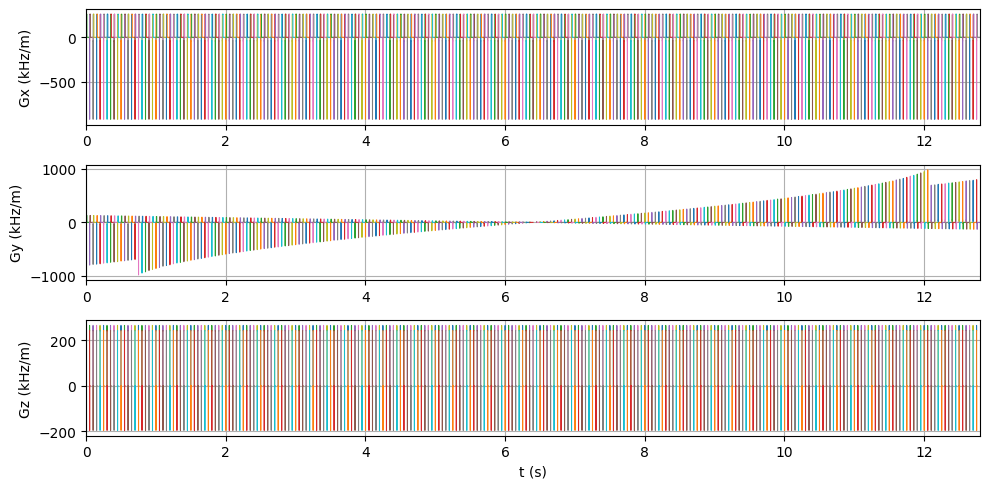

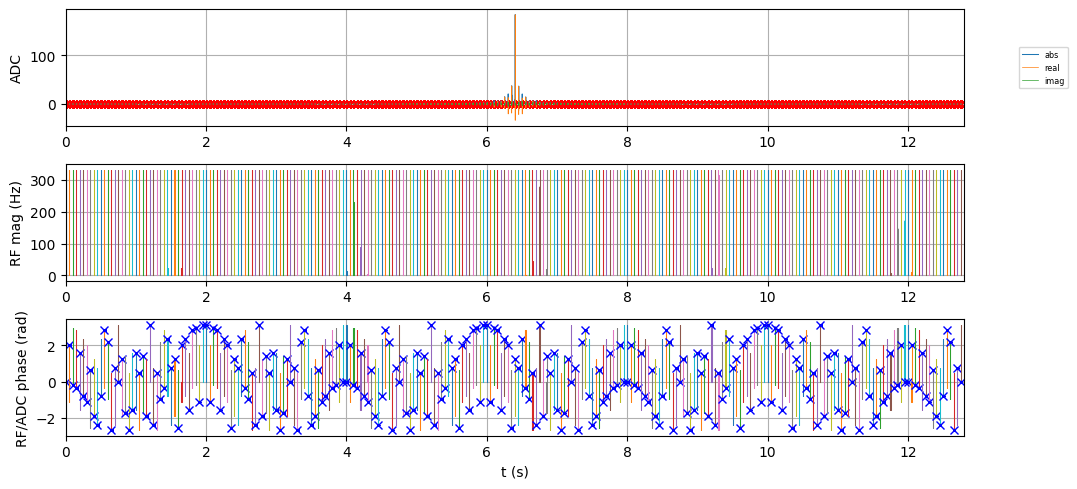

reconstruct and plot


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


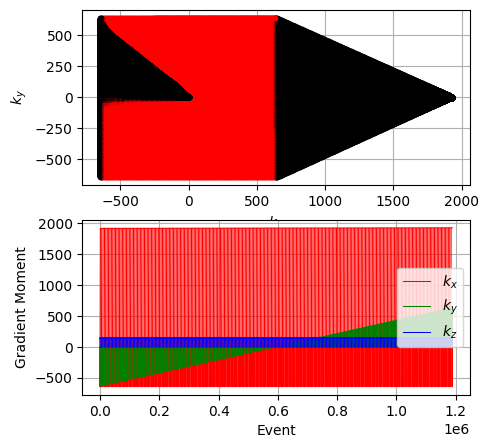

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


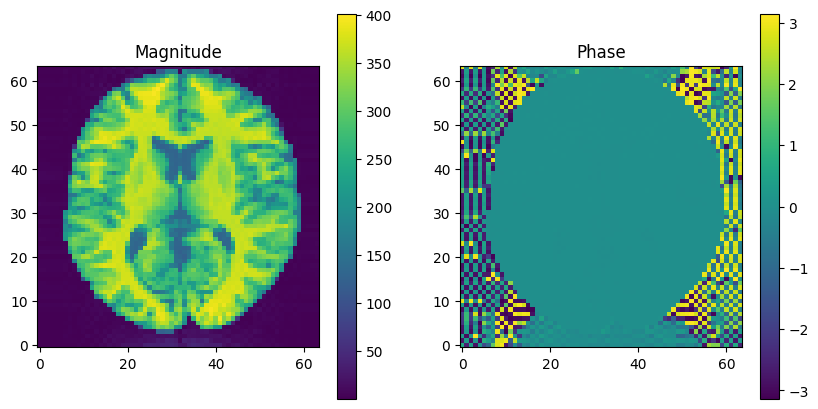

In [11]:
#@title 3. Plot sequence and reconstructed image

if True: # 1.4
    # This works since pypulseq 1.4, which introduced the plot_now argument
    seq.plot(plot_now=False)
    mr0.util.insert_signal_plot(seq, signal.numpy())
    plt.show()
else:
    # This works for older pypulseq versions expect the newest dev branch
    sp_adc, t_adc = mr0.util.pulseq_plot(seq=seq,signal=signal.numpy())

# Unfortunately, we need to limit the resolution as reco_adjoint is very RAM-hungy
print('reconstruct and plot')
seq0.plot_kspace_trajectory()

reco = mr0.reco_adjoint(signal, seq0.get_kspace(), resolution=(64, 64, 1), FOV=(0.2, 0.2, 1))
plt.figure()
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco[:, :, 0].T.abs(), origin="lower")
plt.colorbar()
plt.subplot(122)
plt.title("Phase")
plt.imshow(reco[:, :, 0].T.angle(), origin="lower", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()